Code in this notebook is largely based on <https://github.com/MBMS80/Writing-Cifar10-dataset-to-image-files-as-.tif-or-.jpg->  
( original author:
[Mehdi Maboudi](https://www.tu-braunschweig.de/igp/mitarbeiter/maboudi/), September 2019,
 Technical University of Braunschweig )
 
Implements:
- Writing Cifar10 dataset to image files as '.tif' or '.jpg'  
- Reading image files into numpy arrays compatible with the standard Cifar10 dataset

In [1]:
import os
import glob
import pickle
from pathlib import Path

In [2]:
#!pip install numpy
#!pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
#!pip install imageio
import imageio #Python library for reading and writing image data

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='iso-8859-1')
    return dict

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.  
There are 50000 training images and 10000 test images.  
***
__png__ images of CIFAR-10 will be saved in 10 subdirectories of each label under the __test__ and __train__ directories as below.


In [5]:
# class_names = ['airplane',
# 'automobile',
# 'bird',
# 'cat',
# 'deer',
# 'dog',
# 'frog',
# 'horse',
# 'ship',
# 'truck']
# nb_classes = len(class_names)

In [6]:
# Load cifar10 from local files
data_dir   = './data/'
cifar10_dir   = data_dir + 'cifar-10-batches-py/'

In [7]:
training_batch_pickle_files = sorted(glob.glob(cifar10_dir + 'data_batch_*'))
test_batch_pickle_file = cifar10_dir + 'test_batch'
meta_data_pickle_file  = cifar10_dir + 'batches.meta'

print(training_batch_pickle_files)

['./data/cifar-10-batches-py/data_batch_1', './data/cifar-10-batches-py/data_batch_2', './data/cifar-10-batches-py/data_batch_3', './data/cifar-10-batches-py/data_batch_4', './data/cifar-10-batches-py/data_batch_5']


In [8]:
meta_data = unpickle(meta_data_pickle_file)
# print(meta_data)
# {'num_cases_per_batch': 10000,
# 'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
# 'num_vis': 3072}

In [9]:
class_names = meta_data['label_names']
nb_classes = len(class_names)
print(nb_classes, class_names)

10 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [10]:
cifar_data = []
for pickle_file in training_batch_pickle_files:
    data_dict = unpickle(pickle_file)
    print(f"{data_dict['batch_label']}: len={len(data_dict['labels'])} {data_dict.keys()}")
    assert(len(data_dict['labels']) == len(data_dict['data']))
    assert(len(data_dict['labels']) == len(data_dict['filenames']))
    cifar_data.append(data_dict)
    
print()
test_batch = unpickle(test_batch_pickle_file)
print(f"{test_batch['batch_label']}: len={len(test_batch['labels'])} {test_batch.keys()}")


training batch 1 of 5: len=10000 dict_keys(['batch_label', 'labels', 'data', 'filenames'])
training batch 2 of 5: len=10000 dict_keys(['batch_label', 'labels', 'data', 'filenames'])
training batch 3 of 5: len=10000 dict_keys(['batch_label', 'labels', 'data', 'filenames'])
training batch 4 of 5: len=10000 dict_keys(['batch_label', 'labels', 'data', 'filenames'])
training batch 5 of 5: len=10000 dict_keys(['batch_label', 'labels', 'data', 'filenames'])

testing batch 1 of 1: len=10000 dict_keys(['batch_label', 'labels', 'data', 'filenames'])


In [11]:
print(data_dict['batch_label'], len(data_dict['filenames']), data_dict['filenames'][0:5])
cifar10_batch5 = cifar_data[4]['data'] 
print("dtype:", cifar10_batch5.dtype, "shape:", cifar10_batch5.shape)
print(cifar10_batch5)


training batch 5 of 5 10000 ['compact_car_s_001706.png', 'icebreaker_s_001689.png', 'peke_s_000545.png', 'convertible_s_000520.png', 'domestic_dog_s_000455.png']
dtype: uint8 shape: (10000, 3072)
[[255 252 253 ... 173 231 248]
 [127 126 127 ... 102 108 112]
 [116  64  19 ...   7   6   5]
 ...
 [ 35  40  42 ...  77  66  50]
 [189 186 185 ... 169 171 171]
 [229 236 234 ... 173 162 161]]


In [12]:
def reshape_cifar_img_data(imgdata_batch):
    reshaped = np.reshape(imgdata_batch, (imgdata_batch.shape[0], 3, 32, 32))
    # print(reshaped.shape, end=' ')
    reshaped = np.transpose(reshaped, axes=(0,2,3,1))
    # print("->", reshaped.shape)
    return reshaped

def reshape_cifar_img(imgdata):
    reshaped = np.reshape(imgdata, (3, 32, 32))
    # print(reshaped.shape, end=' ')
    reshaped = np.transpose(reshaped, axes=(1,2,0))
    # print("->", reshaped.shape)
    return reshaped


In [13]:
# # Load cifar10 training and test sets from keras
# from keras.datasets import cifar10
# (X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [14]:
# # cifar10_data = np.load(data_dir + '/cifar10.npz')

# X_train = cifar10_data['X_train']
# y_train = cifar10_data['y_train']
# X_test = cifar10_data['X_test']
# y_test = cifar10_data['y_test']
# print('train:',X_train.shape)
# print('train_labels:',y_train.shape)
# print('test:',X_test.shape)
# print('test_labels:',y_test.shape)

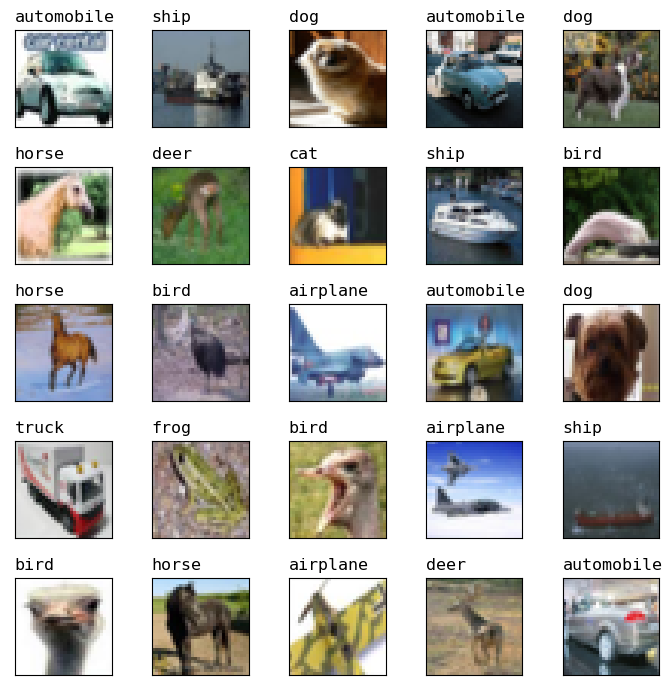

In [15]:
# VISUALIZE IMAGES

def plotImages_categories( images, labels, n_rows=5, n_cols=4, figsize=(10, 10)):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    for i in range(len(axes)):
        # y_train[0].astype(int)
        axes[i].imshow(images[i])        
        axes[i].set_xticks(())
        axes[i].set_yticks(())
        
        class_index = labels[i]
        title = class_names[class_index]
        axes[i].set_title(title, fontdict={'family':'monospace'}, loc='left')
    plt.tight_layout()
    plt.show()

#train_labels =np.ravel(y_train)
reshaped_batch5 = reshape_cifar_img_data(cifar_data[4]['data'])
# print(reshaped_batch5[0])
plotImages_categories(images=reshaped_batch5, labels=cifar_data[4]['labels'], n_rows=5, n_cols=5, figsize=(7, 7))

### Helper function to make directories and write images

In [16]:
def make_directories(images_dir,split):
    for dir_name in class_names:
        dir_full_path = os.path.join(images_dir+'/'+split,dir_name)
        if not os.path.exists(dir_full_path):
            os.makedirs(dir_full_path)

def write_images_to_split_directory(batch,split,path,write_data=False,class_counter=None):
    if class_counter is None:
        class_counter=np.zeros(nb_classes,dtype=int)

    if write_data:
        make_directories(path,split=split)
    images,labels = reshape_cifar_img_data(batch['data']), batch['labels']
    filenames = batch['filenames']
    n_images = images.shape[0]       # number of images: one data tuple per image
    assert n_images==len(labels)     # each image has a class label
    assert n_images==len(filenames)  # each image has a filename
    for i in range(n_images):
        class_index = labels[i]
        class_  = class_names[class_index]
        destination_dir = os.path.join(images_dir,split,class_)
        filename = Path(filenames[i]).stem
        outputname = f"{class_counter[class_index]:04d}_{filename}{im_format}"
        # if i % 200 == 0:
        #     print(destination_dir, outputname)
        if write_data:
            imageio.imwrite(destination_dir+'/'+outputname, images[i], im_format)
        class_counter[class_index] +=1 
        
    print('classnames',class_names)
    print('images/class = ',class_counter)
    return class_counter


In [17]:
write_data = True 
im_format = '.png'  # '.tif'
images_dir = data_dir+'Cifar10_images'
class_counter=np.zeros(nb_classes,dtype=int)

split = 'train'
for batch in cifar_data:
    # train_labels = batch['labels'] #np.ravel(y_train)
    
    print(f"\nWriting {batch['batch_label']}: {len(batch['labels'])} images to {images_dir}/{split}")

    write_images_to_split_directory(batch, split=split, path=images_dir,
                                    write_data=write_data, class_counter=class_counter)        

split = 'test'
print(f"\nWriting {test_batch['batch_label']}: {len(test_batch['labels'])} images to '{split}'")
test_counter = write_images_to_split_directory(test_batch, split=split, path=images_dir,
                                    write_data=write_data, class_counter=None)        

print()


Writing training batch 1 of 5: 10000 images to ./data/Cifar10_images/train
classnames ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images/class =  [1005  974 1032 1016  999  937 1030 1001 1025  981]

Writing training batch 2 of 5: 10000 images to ./data/Cifar10_images/train
classnames ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images/class =  [1989 1981 2042 2011 2009 1925 2038 2027 2012 1966]

Writing training batch 3 of 5: 10000 images to ./data/Cifar10_images/train
classnames ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images/class =  [2983 3023 3007 3008 2999 2954 3016 3042 2973 2995]

Writing training batch 4 of 5: 10000 images to ./data/Cifar10_images/train
classnames ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images/class =  [3986 3986 4048 3984 4003 3975 4020 4023 3997 3978]

Writing trainin

horse
./data/Cifar10_images/train/horse/0000_*.png
./data/Cifar10_images/train/horse/0000_cow_pony_s_001168.png
(32, 32, 3)
(3, 1024)
(3072,)


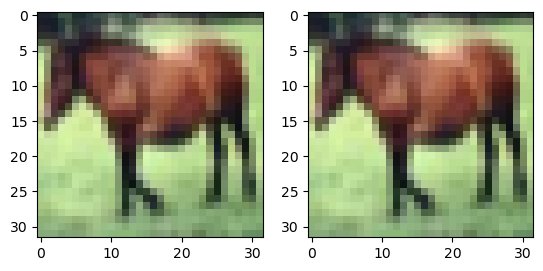

sample min & max: 9 248
source min & max: 9 248

sample patch:
 [[35 34 44 83 84]
 [30 28 31 58 78]
 [36 33 30 54 95]
 [52 50 47 61 89]
 [95 87 74 47 43]]
source patch:
 [[35 34 44 83 84]
 [30 28 31 58 78]
 [36 33 30 54 95]
 [52 50 47 61 89]
 [95 87 74 47 43]]


In [28]:
# Check results visually
sample_idx = 7 # 0, 1, 3, 4, 6, 7  (assumption: first image in a given class) 
sample_class = cifar_data[0]['labels'][sample_idx]
sample_origdata = cifar_data[0]['data'][sample_idx]
print(class_names[sample_class])
filepattern = f"{images_dir}/train/{class_names[sample_class]}/0000_*{im_format}"
print(filepattern)
sample_file = glob.glob(filepattern)[0]
print(sample_file)


#sample  = imageio.imread('data/Cifar10_images/train/frog/0000'+im_format)
sample  = imageio.v2.imread(sample_file)
print(sample.shape)
plt.subplot(1,2,1)
plt.imshow(sample)
reshaped_sample = np.reshape(np.transpose(sample,axes=(2,0,1)),(sample.shape[2],sample.shape[0]*sample.shape[1]))
print(reshaped_sample.shape)

plt.subplot(1,2,2)
print(sample_origdata.shape)
sample_img = reshape_cifar_img(sample_origdata)
plt.imshow(sample_img)
plt.show()

# Check results numerically
print('sample min & max:',sample.min(),sample.max())
print('source min & max:',sample_origdata.min(),sample_origdata.max())
print('\nsample patch:\n',sample[0:5,0:5,1])
print('source patch:\n',sample_img[0:5,0:5,1])